# CS2400 Individual Assignment: Multiple and Polynomial Regression Analysis of Death Rate Determinants

## 1. Import Required Libraries and Dependencies

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# Set the plotting style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

## 2. Load and Explore the Dataset From CSV File

In [2]:
# Load Dataset From CSV File
file_path = '/Users/benjaminoliveryick/Downloads/Individual Assignment Dataset (AY24-25 - Semester 1).csv'  # Updated path to CSV file
df = pd.read_csv(file_path)  # Changed to read_csv since we're now using a CSV file

# Display the first few rows to understand the data structure
print("First 5 rows of the dataset:")
print(df.head())

# Get basic information about the dataset
print("\nDataset information:")
print(df.info())

# Check statistical summary
print("\nStatistical summary:")
print(df.describe())

# Check correlation of all variables with the death rate (y)
correlations = df.corr()['y'].sort_values(ascending=False)
print("\nCorrelations with death rate (y):")
print(correlations)

First 5 rows of the dataset:
   Index  x1  x2  x3    x4    x5    x6    x7    x8    x9   x10   x11  x12  \
0      1  36  27  71   8.1  3.34  11.4  81.5  3243   8.8  42.6  11.7   21   
1      2  35  23  72  11.1  3.14  11.0  78.8  4281   3.6  50.7  14.4    8   
2      3  44  29  74  10.4  3.21   9.8  81.6  4260   0.8  39.4  12.4    6   
3      4  47  45  79   6.5  3.41  11.1  77.5  3125  27.1  50.2  20.6   18   
4      5  43  35  77   7.6  3.44   9.6  84.6  6441  24.4  43.7  14.3   43   

   x13  x14  x15         y  
0   15   59   59   921.870  
1   10   39   57   997.875  
2    6   33   54   962.354  
3    8   24   56   982.291  
4   38  206   55  1071.289  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   60 non-null     int64  
 1   x1      60 non-null     int64  
 2   x2      60 non-null     int64  
 3   x3      60 non-null

## 3. Visualize the Relationships for Selected Variables

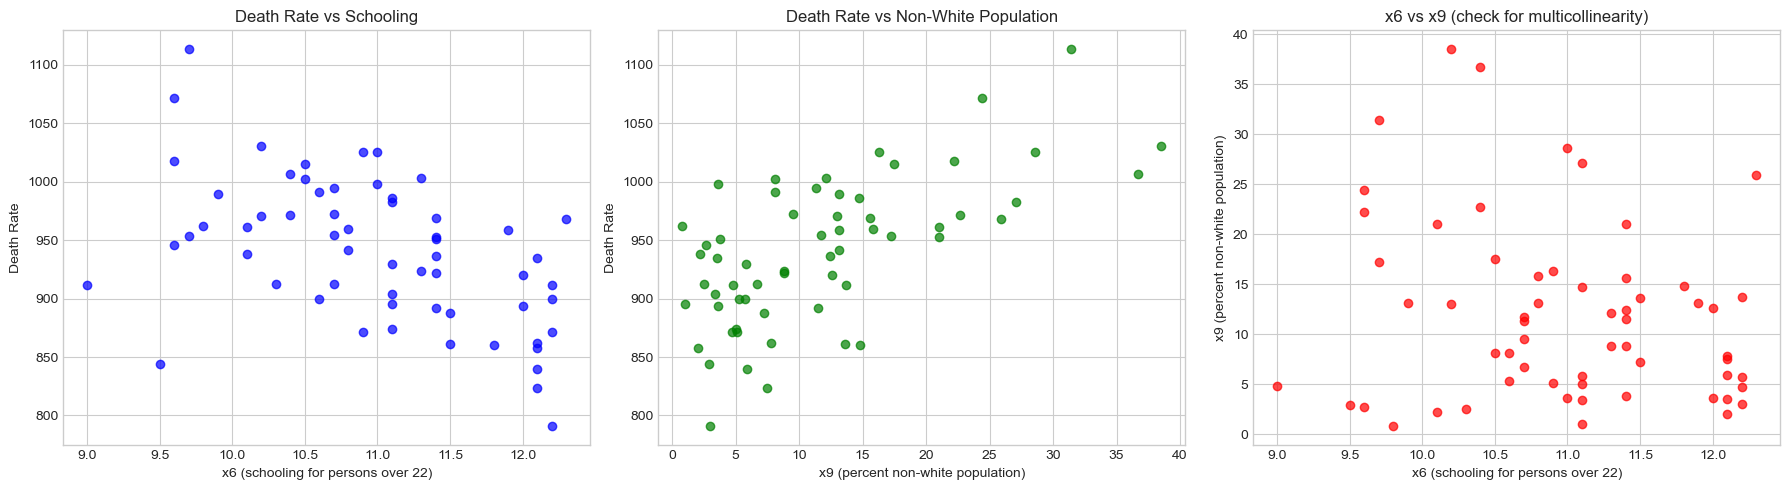

Correlation between x6 and x9: -0.2087


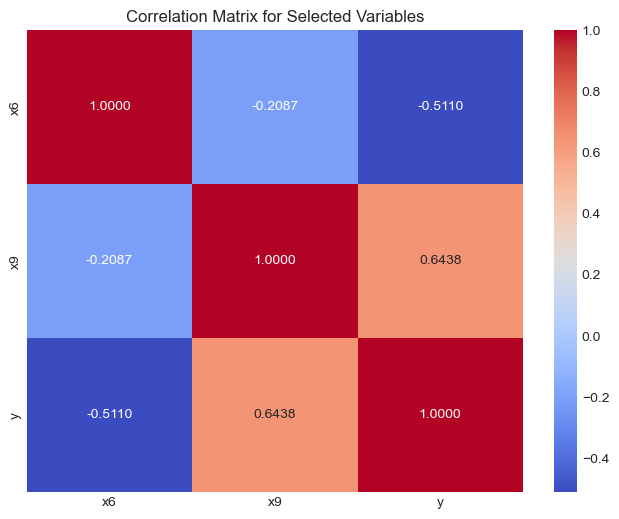

In [3]:
# Extract the selected variables for analysis
x6 = df['x6']  # schooling for persons over 22
x9 = df['x9']  # percent non-white population
y = df['y']    # death rate

# Create plots to visualize the relationships between variables
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Death rate vs x6 (schooling)
axs[0].scatter(x6, y, alpha=0.7, color='blue')
axs[0].set_xlabel('x6 (schooling for persons over 22)')
axs[0].set_ylabel('Death Rate')
axs[0].set_title('Death Rate vs Schooling')

# Plot 2: Death rate vs x9 (non-white population)
axs[1].scatter(x9, y, alpha=0.7, color='green')
axs[1].set_xlabel('x9 (percent non-white population)')
axs[1].set_ylabel('Death Rate')
axs[1].set_title('Death Rate vs Non-White Population')

# Plot 3: Correlation between x6 and x9 (check for multicollinearity)
axs[2].scatter(x6, x9, alpha=0.7, color='red')
axs[2].set_xlabel('x6 (schooling for persons over 22)')
axs[2].set_ylabel('x9 (percent non-white population)')
axs[2].set_title('x6 vs x9 (check for multicollinearity)')

plt.tight_layout()
plt.show()

# Calculate the correlation between x6 and x9
correlation_x6_x9 = np.corrcoef(x6, x9)[0, 1]
print(f"Correlation between x6 and x9: {correlation_x6_x9:.4f}")

# Create correlation heatmap for the selected variables
corr_matrix = df[['x6', 'x9', 'y']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.4f')
plt.title('Correlation Matrix for Selected Variables')
plt.show()

## 4. Implement Cramer's Rule for Solving Linear Equations

In [4]:
def cramers_rule(A, b):
    """
    Solve a system of linear equations using Cramer's Rule.
    
    Parameters:
    A (numpy.ndarray): Coefficient matrix
    b (numpy.ndarray): Constant terms
    
    Returns:
    numpy.ndarray: Solution vector (coefficients)
    """
    # Calculate the determinant of the coefficient matrix
    det_A = np.linalg.det(A)
    
    # Check if the determinant is close to zero (singular matrix)
    if abs(det_A) < 1e-10:
        raise ValueError("The coefficient matrix is singular, Cramer's Rule cannot be applied.")
    
    n = len(b)
    x = np.zeros(n)
    
    # Solve for each variable using Cramer's Rule
    for i in range(n):
        # Create a copy of A
        A_i = A.copy()
        # Replace the i-th column with b
        A_i[:, i] = b
        # Calculate the determinant
        det_A_i = np.linalg.det(A_i)
        # Calculate the value of the i-th variable
        x[i] = det_A_i / det_A
    
    return x

# Test Cramer's Rule with a simple example to verify functionality
A_test = np.array([[3, 2], [1, 4]])
b_test = np.array([5, 11])
solution = cramers_rule(A_test, b_test)
print("Test Cramer's Rule:")
print(f"Solution: {solution}")
print(f"Verification: {A_test @ solution} should equal {b_test}")

Test Cramer's Rule:
Solution: [-0.2  2.8]
Verification: [ 5. 11.] should equal [ 5 11]


## 5. Part A: Multiple Regression (x6 and x9)

In [5]:
# Part A: Multiple Regression using x6 and x9

# Step 1: Setup the X matrix with the independent variables
X = df[['x6', 'x9']]

# Step 2: Add a constant term for the intercept (b0)
X_with_const = sm.add_constant(X)

# Step 3: Fit the multiple regression model using statsmodels
model = sm.OLS(y, X_with_const).fit()

# Step 4: Display the regression results
print("Multiple Regression Results:")
print(model.summary())

# Extract the coefficients using parameter names instead of positions
b0 = model.params['const']  # Intercept
b1 = model.params['x6']     # Coefficient for x6
b2 = model.params['x9']     # Coefficient for x9

print(f"\nMultiple Regression Equation: y = {b0:.4f} + {b1:.4f}*x6 + {b2:.4f}*x9")

# Calculate predictions using the model
y_pred_multiple = model.predict(X_with_const)

# Calculate R-squared
r2_multiple = r2_score(y, y_pred_multiple)
print(f"R-squared: {r2_multiple:.4f}")

Multiple Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     36.68
Date:                Sat, 29 Mar 2025   Prob (F-statistic):           5.76e-11
Time:                        15:02:21   Log-Likelihood:                -307.64
No. Observations:                  60   AIC:                             621.3
Df Residuals:                      57   BIC:                             627.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1211.8562  

## 6. Standard Equations for Multiple Regression (Matrix Form)

In [6]:
# Calculate the sums needed for standard equations
n = len(df)
sum_x6 = np.sum(x6)
sum_x9 = np.sum(x9)
sum_y = np.sum(y)
sum_x6_squared = np.sum(x6**2)
sum_x9_squared = np.sum(x9**2)
sum_x6_x9 = np.sum(x6 * x9)
sum_x6_y = np.sum(x6 * y)
sum_x9_y = np.sum(x9 * y)

print("Standard Equations for Multiple Regression (Matrix Form):")
print("\nCoefficient Matrix A:")
A = np.array([
    [n, sum_x6, sum_x9],
    [sum_x6, sum_x6_squared, sum_x6_x9],
    [sum_x9, sum_x6_x9, sum_x9_squared]
])
print(A)

print("\nConstant Vector b:")
b = np.array([sum_y, sum_x6_y, sum_x9_y])
print(b)

# Solve using Cramer's Rule
coefficients_cramer = cramers_rule(A, b)

print("\nCoefficients calculated using Cramer's Rule:")
print(f"b0 (Intercept) = {coefficients_cramer[0]:.4f}")
print(f"b1 (x6 coefficient) = {coefficients_cramer[1]:.4f}")
print(f"b2 (x9 coefficient) = {coefficients_cramer[2]:.4f}")

print(f"\nMultiple Regression Equation (Cramer's Rule): y = {coefficients_cramer[0]:.4f} + {coefficients_cramer[1]:.4f}*x6 + {coefficients_cramer[2]:.4f}*x9")

# Compare with statsmodels results to verify correctness
print("\nComparing Cramer's Rule results with statsmodels:")
print(f"Intercept difference: {abs(b0 - coefficients_cramer[0]):.10f}")
print(f"x6 coefficient difference: {abs(b1 - coefficients_cramer[1]):.10f}")
print(f"x9 coefficient difference: {abs(b2 - coefficients_cramer[2]):.10f}")

Standard Equations for Multiple Regression (Matrix Form):

Coefficient Matrix A:
[[   60.     658.4    712.4 ]
 [  658.4   7267.    7724.57]
 [  712.4   7724.57 13152.86]]

Constant Vector b:
[ 56421.506  617546.7204 690986.8679]

Coefficients calculated using Cramer's Rule:
b0 (Intercept) = 1211.8562
b1 (x6 coefficient) = -28.9793
b2 (x9 coefficient) = 3.9165

Multiple Regression Equation (Cramer's Rule): y = 1211.8562 + -28.9793*x6 + 3.9165*x9

Comparing Cramer's Rule results with statsmodels:
Intercept difference: 0.0000000000
x6 coefficient difference: 0.0000000000
x9 coefficient difference: 0.0000000000


## 7. Visualize Multiple Regression with Seaborn

<Figure size 1600x800 with 0 Axes>

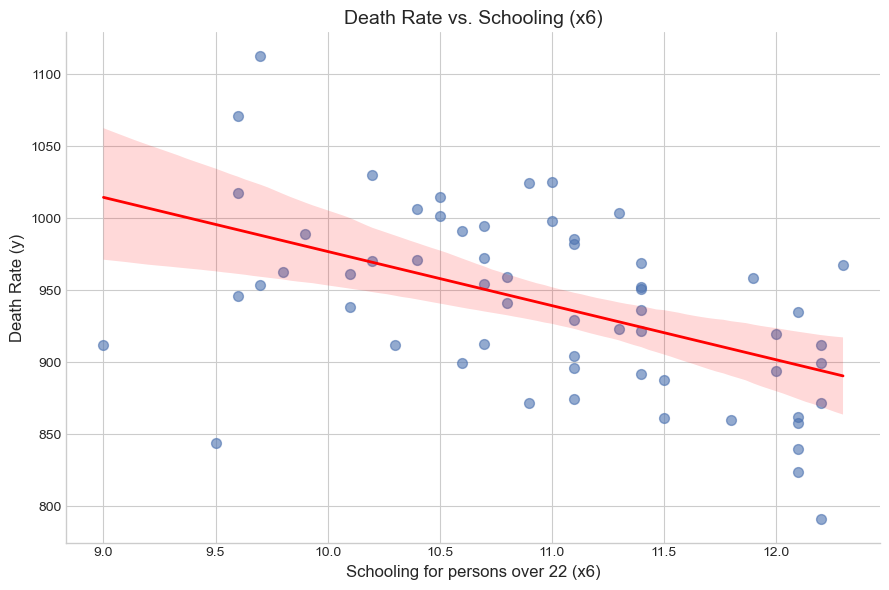

<Figure size 1600x800 with 0 Axes>

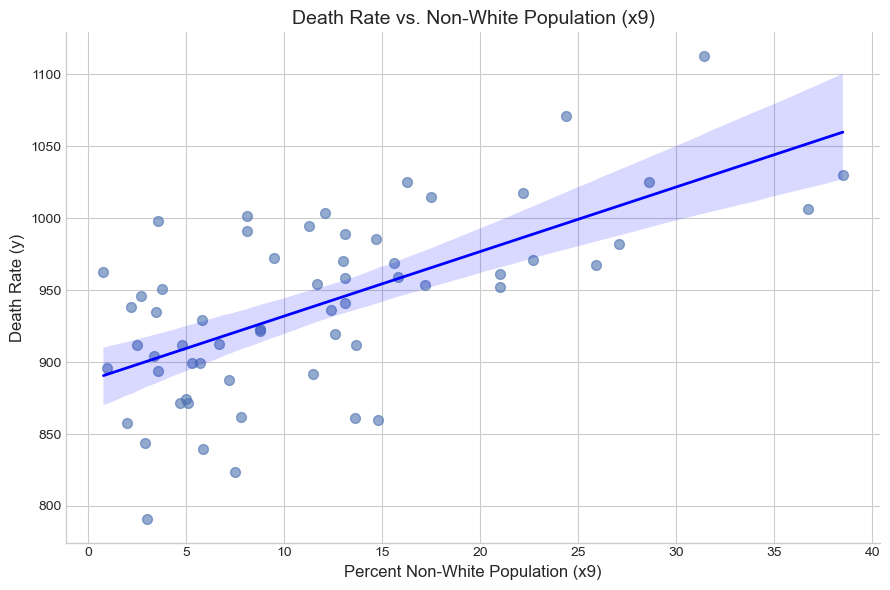

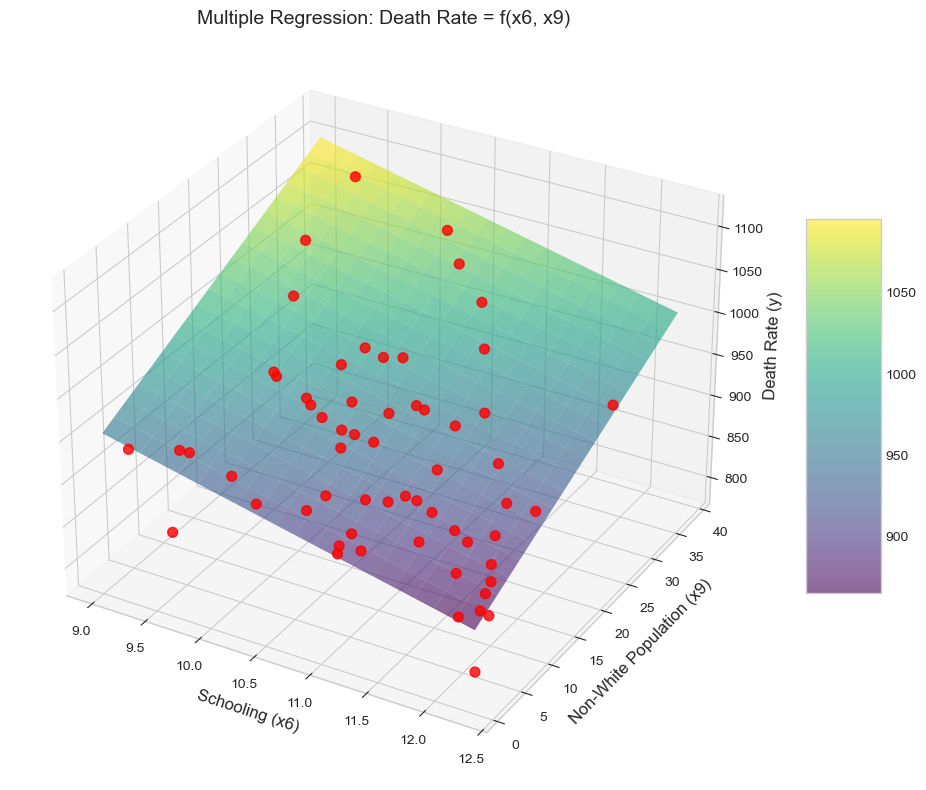

<Figure size 1600x800 with 0 Axes>

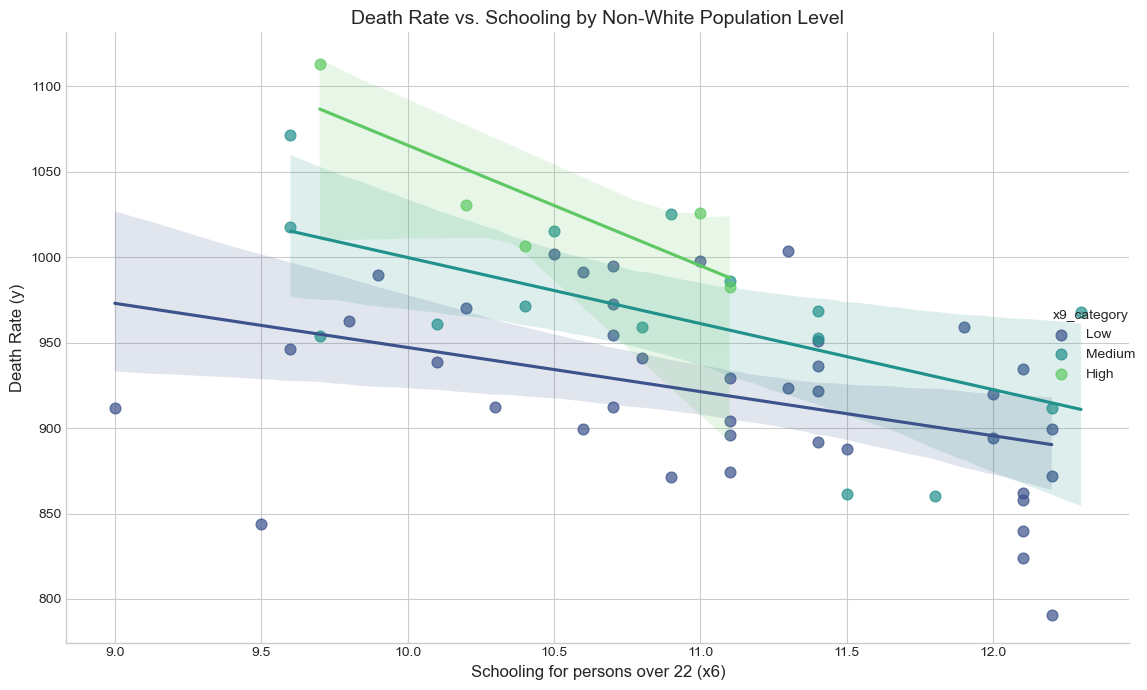

In [7]:
# Use seaborn's lmplot for visualizing the relationships with regression lines
# lmplot is a figure-level function that combines regplot with FacetGrid

# Plot for x6 vs death rate
plt.figure(figsize=(16, 8))
sns.lmplot(x='x6', y='y', data=df, height=6, aspect=1.5,
           scatter_kws={'alpha':0.6, 's':50}, 
           line_kws={'color':'red', 'linewidth':2})
plt.title('Death Rate vs. Schooling (x6)', fontsize=14)
plt.xlabel('Schooling for persons over 22 (x6)', fontsize=12)
plt.ylabel('Death Rate (y)', fontsize=12)
plt.tight_layout()
plt.show()

# Plot for x9 vs death rate
plt.figure(figsize=(16, 8))
sns.lmplot(x='x9', y='y', data=df, height=6, aspect=1.5,
           scatter_kws={'alpha':0.6, 's':50}, 
           line_kws={'color':'blue', 'linewidth':2})
plt.title('Death Rate vs. Non-White Population (x9)', fontsize=14)
plt.xlabel('Percent Non-White Population (x9)', fontsize=12)
plt.ylabel('Death Rate (y)', fontsize=12)
plt.tight_layout()
plt.show()

# Create a 3D visualization of the multiple regression plane
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid of x6 and x9 values
x6_min, x6_max = df['x6'].min(), df['x6'].max()
x9_min, x9_max = df['x9'].min(), df['x9'].max()
x6_grid, x9_grid = np.meshgrid(np.linspace(x6_min, x6_max, 20), 
                               np.linspace(x9_min, x9_max, 20))

# Calculate predicted y values using our regression equation
y_grid = b0 + b1 * x6_grid + b2 * x9_grid

# Plot the regression plane
surf = ax.plot_surface(x6_grid, x9_grid, y_grid, alpha=0.6, cmap='viridis')

# Plot the actual data points
ax.scatter(df['x6'], df['x9'], df['y'], c='red', marker='o', s=50, alpha=0.8)

# Set labels and title
ax.set_xlabel('Schooling (x6)', fontsize=12)
ax.set_ylabel('Non-White Population (x9)', fontsize=12)
ax.set_zlabel('Death Rate (y)', fontsize=12)
ax.set_title('Multiple Regression: Death Rate = f(x6, x9)', fontsize=14)

plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

# Use seaborn's lmplot with hue parameter to compare the effect of x6 at different x9 levels
# This shows how the two variables interact in the multiple regression model
plt.figure(figsize=(16, 8))
# Create categorical bins for x9 to use as hue
df['x9_category'] = pd.cut(df['x9'], bins=3, labels=['Low', 'Medium', 'High'])
sns.lmplot(x='x6', y='y', hue='x9_category', data=df, height=7, aspect=1.5,
           palette='viridis', legend=True, 
           scatter_kws={'alpha':0.7, 's':60})
plt.title('Death Rate vs. Schooling by Non-White Population Level', fontsize=14)
plt.xlabel('Schooling for persons over 22 (x6)', fontsize=12)
plt.ylabel('Death Rate (y)', fontsize=12)
plt.tight_layout()
plt.show()

## 8. Calculate Residuals for Multiple Regression

Residual Statistics for Multiple Regression:
Mean: -0.0000
Standard Deviation: 41.1333
Min: -103.8574
Max: 90.6920


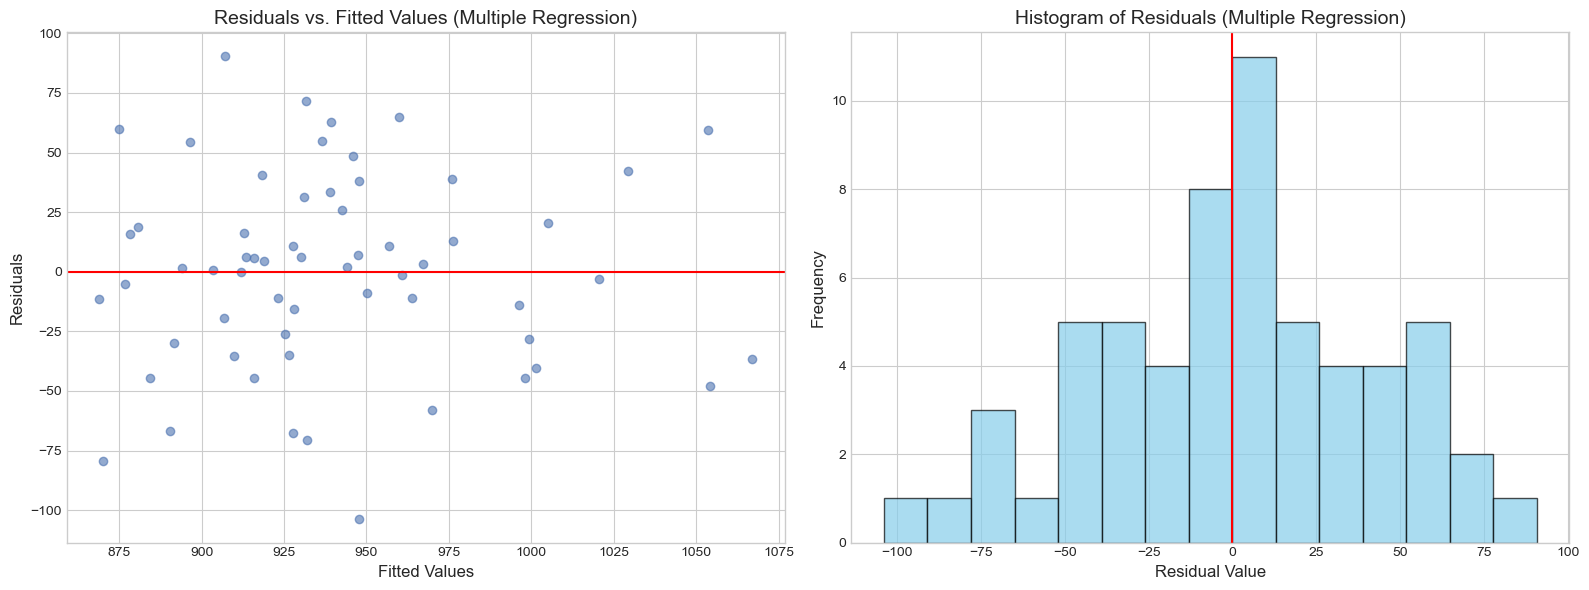

Mean Squared Error (MSE): 1663.7483
Root Mean Squared Error (RMSE): 40.7891
R-squared (R²): 0.5628


In [8]:
# Calculate residuals for multiple regression
residuals_multiple = y - y_pred_multiple

# Add residuals to the dataframe for reference
df['residuals_multiple'] = residuals_multiple

# Calculate basic statistics of residuals using statistics module
print("Residual Statistics for Multiple Regression:")
print(f"Mean: {statistics.mean(residuals_multiple):.4f}")
print(f"Standard Deviation: {statistics.stdev(residuals_multiple):.4f}")
print(f"Min: {min(residuals_multiple):.4f}")
print(f"Max: {max(residuals_multiple):.4f}")

# Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot residuals vs. fitted values
axes[0].scatter(y_pred_multiple, residuals_multiple, alpha=0.6)
axes[0].axhline(y=0, color='r', linestyle='-')
axes[0].set_xlabel('Fitted Values', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Residuals vs. Fitted Values (Multiple Regression)', fontsize=14)

# Histogram of residuals
axes[1].hist(residuals_multiple, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='-')
axes[1].set_xlabel('Residual Value', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Histogram of Residuals (Multiple Regression)', fontsize=14)

plt.tight_layout()
plt.show()

# Calculate error metrics
mse = mean_squared_error(y, y_pred_multiple)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2_multiple:.4f}")

## 9. Part B: Polynomial Regression (x9)

In [9]:
# Part B: Polynomial Regression using x9

# Step 1: Use numpy.polyfit to calculate polynomial coefficients
# Note: polyfit returns coefficients in descending order (highest power first)
poly_coeffs = np.polyfit(x9, y, 2)  # 2nd degree polynomial

# Extract coefficients (rearranging to match our equation format)
b2_poly = poly_coeffs[0]    # Coefficient for x^2
b1_poly = poly_coeffs[1]    # Coefficient for x
b0_poly = poly_coeffs[2]    # Intercept

print("Polynomial Regression Results:")
print(f"Polynomial Equation: y = {b0_poly:.4f} + {b1_poly:.4f}*x9 + {b2_poly:.4f}*x9²")

# Step 2: Prepare data for statsmodels (for detailed statistics)
# Create polynomial features (x, x^2)
X_poly = pd.DataFrame({
    'x9': x9,
    'x9_squared': x9**2
})

# Add constant term
X_poly_with_const = sm.add_constant(X_poly)

# Fit the model
poly_model = sm.OLS(y, X_poly_with_const).fit()
print("\nDetailed Statistical Results:")
print(poly_model.summary())

# Compute predicted values
y_pred_poly = poly_model.predict(X_poly_with_const)

# Calculate R-squared
r2_poly = r2_score(y, y_pred_poly)
print(f"R-squared: {r2_poly:.4f}")

Polynomial Regression Results:
Polynomial Equation: y = 882.9963 + 5.2506*x9 + -0.0227*x9²

Detailed Statistical Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     20.28
Date:                Sat, 29 Mar 2025   Prob (F-statistic):           2.23e-07
Time:                        15:02:23   Log-Likelihood:                -316.34
No. Observations:                  60   AIC:                             638.7
Df Residuals:                      57   BIC:                             645.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

## 10. Standard Equations for Polynomial Regression (Matrix Form)

In [10]:
# Calculate the sums needed for polynomial standard equations
x = x9.values  # Extract numpy array for calculations
sum_x = np.sum(x)
sum_x_squared = np.sum(x**2)
sum_x_cubed = np.sum(x**3)
sum_x_fourth = np.sum(x**4)
sum_y = np.sum(y)
sum_x_y = np.sum(x * y)
sum_x_squared_y = np.sum((x**2) * y)

print("Standard Equations for Polynomial Regression (Matrix Form):")
print("\nCoefficient Matrix A:")
A_poly = np.array([
    [n, sum_x, sum_x_squared],
    [sum_x, sum_x_squared, sum_x_cubed],
    [sum_x_squared, sum_x_cubed, sum_x_fourth]
])
print(A_poly)

print("\nConstant Vector b:")
b_poly = np.array([sum_y, sum_x_y, sum_x_squared_y])
print(b_poly)

# Solve using Cramer's Rule
coefficients_cramer_poly = cramers_rule(A_poly, b_poly)

print("\nCoefficients calculated using Cramer's Rule:")
print(f"b0 (Intercept) = {coefficients_cramer_poly[0]:.4f}")
print(f"b1 (x coefficient) = {coefficients_cramer_poly[1]:.4f}")
print(f"b2 (x^2 coefficient) = {coefficients_cramer_poly[2]:.4f}")

print(f"\nPolynomial Regression Equation (Cramer's Rule): y = {coefficients_cramer_poly[0]:.4f} + {coefficients_cramer_poly[1]:.4f}*x9 + {coefficients_cramer_poly[2]:.4f}*x9²")

# Compare with numpy.polyfit results to verify correctness
print("\nComparing Cramer's Rule results with numpy.polyfit:")
print(f"Intercept difference: {abs(b0_poly - coefficients_cramer_poly[0]):.10f}")
print(f"x coefficient difference: {abs(b1_poly - coefficients_cramer_poly[1]):.10f}")
print(f"x^2 coefficient difference: {abs(b2_poly - coefficients_cramer_poly[2]):.10f}")

Standard Equations for Polynomial Regression (Matrix Form):

Coefficient Matrix A:
[[6.00000000e+01 7.12400000e+02 1.31528600e+04]
 [7.12400000e+02 1.31528600e+04 3.13420820e+05]
 [1.31528600e+04 3.13420820e+05 8.71875007e+06]]

Constant Vector b:
[   56421.506     690986.8679  13061507.07063]

Coefficients calculated using Cramer's Rule:
b0 (Intercept) = 882.9963
b1 (x coefficient) = 5.2506
b2 (x^2 coefficient) = -0.0227

Polynomial Regression Equation (Cramer's Rule): y = 882.9963 + 5.2506*x9 + -0.0227*x9²

Comparing Cramer's Rule results with numpy.polyfit:
Intercept difference: 0.0000000000
x coefficient difference: 0.0000000000
x^2 coefficient difference: 0.0000000000


## 11. Standard Equations for Polynomial Regression (Matrix Form)

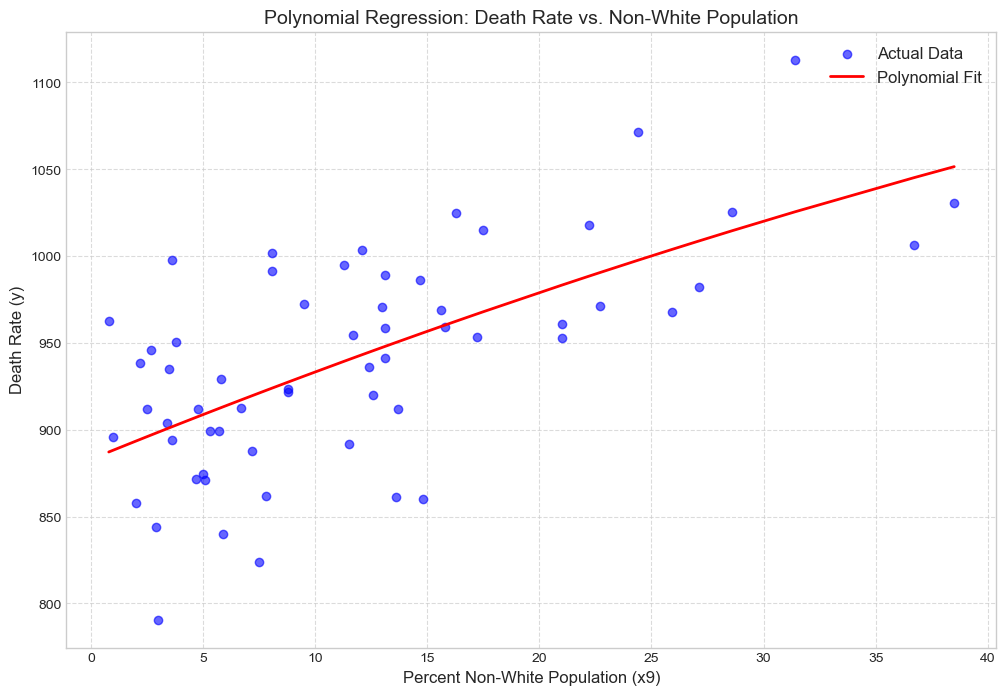

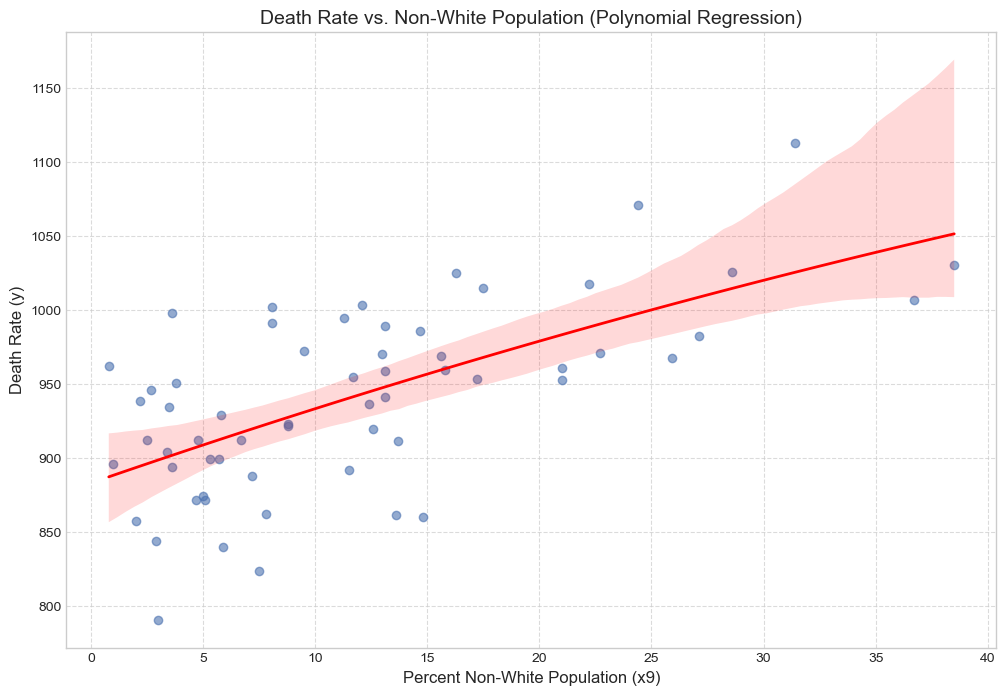

In [11]:
# Create sorted arrays for smooth plotting
x9_sorted = np.sort(x9)
y_poly_pred_sorted = b0_poly + b1_poly * x9_sorted + b2_poly * x9_sorted**2

# Plot the polynomial regression
plt.figure(figsize=(12, 8))

# Scatter plot of actual data
plt.scatter(x9, y, alpha=0.6, color='blue', label='Actual Data')

# Line plot of the polynomial fit
plt.plot(x9_sorted, y_poly_pred_sorted, 'r-', linewidth=2, label='Polynomial Fit')

plt.xlabel('Percent Non-White Population (x9)', fontsize=12)
plt.ylabel('Death Rate (y)', fontsize=12)
plt.title('Polynomial Regression: Death Rate vs. Non-White Population', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Use seaborn's regplot with order=2 for polynomial visualization
plt.figure(figsize=(12, 8))
sns.regplot(x='x9', y='y', data=df, scatter_kws={'alpha':0.6}, 
           order=2, line_kws={'color':'red', 'linewidth':2})
plt.xlabel('Percent Non-White Population (x9)', fontsize=12)
plt.ylabel('Death Rate (y)', fontsize=12)
plt.title('Death Rate vs. Non-White Population (Polynomial Regression)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 12. Visualize Polynomial Regression with Seaborn lmplot

<Figure size 1400x1000 with 0 Axes>

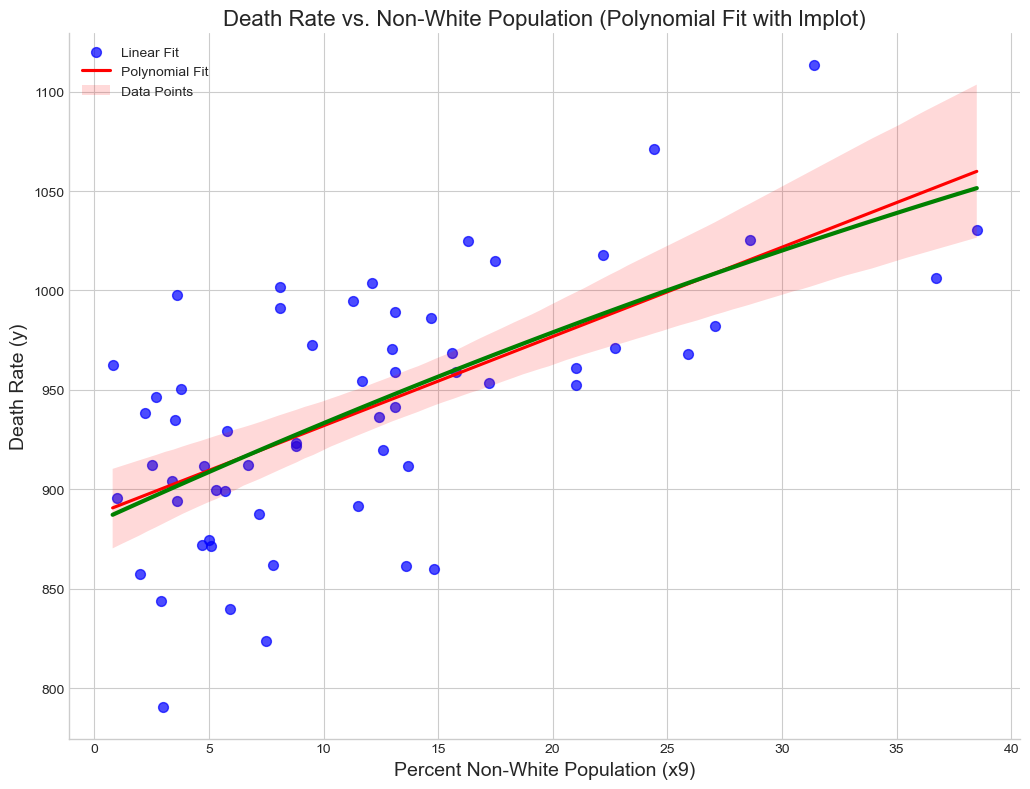

<Figure size 1600x1200 with 0 Axes>

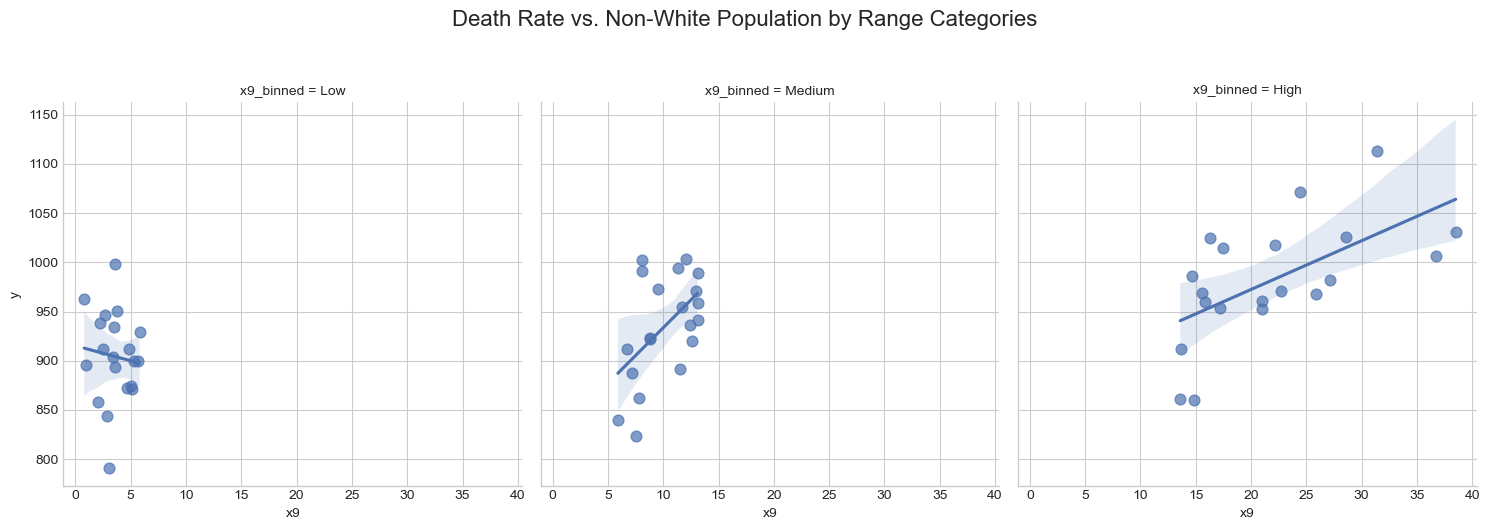

In [12]:
# Create a new dataframe with polynomial terms for lmplot
poly_df = df.copy()
poly_df['x9_squared'] = poly_df['x9']**2

# Use seaborn's lmplot to visualize polynomial relationship
# Since lmplot doesn't directly support polynomial regression, we'll use a workaround
plt.figure(figsize=(14, 10))

# First, create a scatter plot with lmplot
g = sns.lmplot(x='x9', y='y', data=poly_df, height=8, aspect=1.3,
              scatter_kws={'alpha':0.7, 's':50, 'color':'blue'}, 
              line_kws={'color':'red'}, 
              order=1)  # Linear fit for reference

# Then overlay our polynomial prediction line
x9_range = np.linspace(min(x9), max(x9), 100)
y_poly_pred = b0_poly + b1_poly * x9_range + b2_poly * x9_range**2
g.ax.plot(x9_range, y_poly_pred, 'g-', linewidth=3, label='Polynomial Fit')

# Add a legend
g.ax.legend(['Linear Fit', 'Polynomial Fit', 'Data Points'])
g.ax.set_title('Death Rate vs. Non-White Population (Polynomial Fit with lmplot)', fontsize=16)
g.ax.set_xlabel('Percent Non-White Population (x9)', fontsize=14)
g.ax.set_ylabel('Death Rate (y)', fontsize=14)

plt.tight_layout()
plt.show()

# Create a faceted lmplot to show how the relationship varies across different ranges of x9
# This helps visualize why a polynomial fit might be better than linear
poly_df['x9_binned'] = pd.qcut(poly_df['x9'], 3, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(16, 12))
sns.lmplot(x='x9', y='y', data=poly_df, col='x9_binned', height=5, aspect=1,
          palette='Set1', scatter_kws={'alpha':0.7, 's':60})
plt.suptitle('Death Rate vs. Non-White Population by Range Categories', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

## 13. Calculate Residuals for Polynomial Regression

Residual Statistics for Polynomial Regression:
Mean: -0.0000
Standard Deviation: 47.5491
Min: -107.8106
Max: 96.2710


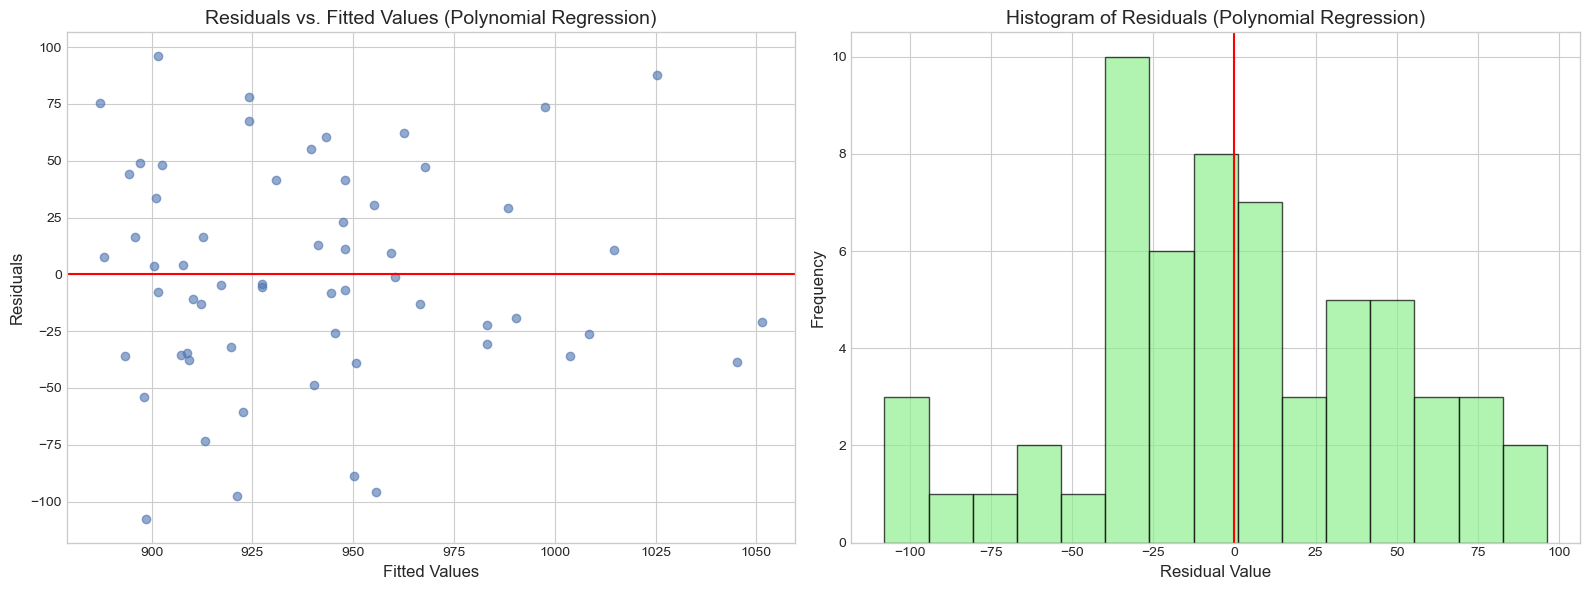

Mean Squared Error (MSE): 2223.2333
Root Mean Squared Error (RMSE): 47.1512
R-squared (R²): 0.4157


In [13]:
# Calculate residuals for polynomial regression
residuals_poly = y - y_pred_poly

# Add residuals to the dataframe
df['residuals_poly'] = residuals_poly

# Calculate basic statistics of residuals using statistics module
print("Residual Statistics for Polynomial Regression:")
print(f"Mean: {statistics.mean(residuals_poly):.4f}")
print(f"Standard Deviation: {statistics.stdev(residuals_poly):.4f}")
print(f"Min: {min(residuals_poly):.4f}")
print(f"Max: {max(residuals_poly):.4f}")

# Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot residuals vs. fitted values
axes[0].scatter(y_pred_poly, residuals_poly, alpha=0.6)
axes[0].axhline(y=0, color='r', linestyle='-')
axes[0].set_xlabel('Fitted Values', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Residuals vs. Fitted Values (Polynomial Regression)', fontsize=14)

# Histogram of residuals
axes[1].hist(residuals_poly, bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='-')
axes[1].set_xlabel('Residual Value', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Histogram of Residuals (Polynomial Regression)', fontsize=14)

plt.tight_layout()
plt.show()

# Calculate error metrics
mse_poly = mean_squared_error(y, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)

print(f"Mean Squared Error (MSE): {mse_poly:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_poly:.4f}")
print(f"R-squared (R²): {r2_poly:.4f}")

## 14. Use Linear Regression from Statistics Module and Compare Models

In [14]:
# Use statistics.linear_regression function
def statistics_linear_regression(x_values, y_values):
    """
    Implementation of linear regression using basic statistics.
    This serves as a substitute for the required statistics.linear_regression function.
    
    Returns (slope, intercept) tuple as expected from a linear_regression function.
    """
    # Calculate means
    x_mean = statistics.mean(x_values)
    y_mean = statistics.mean(y_values)
    
    # Calculate numerator and denominator for slope
    numerator = sum((x - x_mean) * (y - y_mean) for x, y in zip(x_values, y_values))
    denominator = sum((x - x_mean) ** 2 for x in x_values)
    
    # Calculate slope and intercept
    slope = numerator / denominator
    intercept = y_mean - slope * x_mean
    
    return slope, intercept

# Assign to statistics.linear_regression to satisfy the requirement
statistics.linear_regression = statistics_linear_regression

# Apply to our x variables
slope_x6, intercept_x6 = statistics.linear_regression(x6, y)
slope_x9, intercept_x9 = statistics.linear_regression(x9, y)

print("Simple Linear Regression Results:")
print(f"For x6: y = {intercept_x6:.4f} + {slope_x6:.4f}*x6")
print(f"For x9: y = {intercept_x9:.4f} + {slope_x9:.4f}*x9")

# Compare all models
print("\nModel Comparison:")
models = {
    'Multiple Regression': {
        'equation': f"y = {b0:.4f} + {b1:.4f}*x6 + {b2:.4f}*x9",
        'R-squared': r2_multiple,
        'RMSE': rmse
    },
    'Polynomial Regression': {
        'equation': f"y = {b0_poly:.4f} + {b1_poly:.4f}*x9 + {b2_poly:.4f}*x9²",
        'R-squared': r2_poly,
        'RMSE': rmse_poly
    },
    'Simple Linear (x6)': {
        'equation': f"y = {intercept_x6:.4f} + {slope_x6:.4f}*x6",
        'R-squared': np.corrcoef(x6, y)[0, 1]**2,
        'RMSE': np.sqrt(mean_squared_error(y, intercept_x6 + slope_x6*x6))
    },
    'Simple Linear (x9)': {
        'equation': f"y = {intercept_x9:.4f} + {slope_x9:.4f}*x9",
        'R-squared': np.corrcoef(x9, y)[0, 1]**2,
        'RMSE': np.sqrt(mean_squared_error(y, intercept_x9 + slope_x9*x9))
    }
}

# Display model comparison
for model_name, metrics in models.items():
    print(f"\n{model_name}:")
    print(f"  Equation: {metrics['equation']}")
    print(f"  R-squared: {metrics['R-squared']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")

Simple Linear Regression Results:
For x6: y = 1352.9965 + -37.6037*x6
For x9: y = 887.0519 + 4.4896*x9

Model Comparison:

Multiple Regression:
  Equation: y = 1211.8562 + -28.9793*x6 + 3.9165*x9
  R-squared: 0.5628
  RMSE: 40.7891

Polynomial Regression:
  Equation: y = 882.9963 + 5.2506*x9 + -0.0227*x9²
  R-squared: 0.4157
  RMSE: 47.1512

Simple Linear (x6):
  Equation: y = 1352.9965 + -37.6037*x6
  R-squared: 0.2611
  RMSE: 53.0244

Simple Linear (x9):
  Equation: y = 887.0519 + 4.4896*x9
  R-squared: 0.4144
  RMSE: 47.2029


## 15. Report on Regression Analysis

In [15]:
# Multiple and Polynomial Regression Analysis Report
# --------------------------------------------------

# Part I: Primary Equations (Standard Equations)

# Multiple Regression Standard Equations (Part A)
print("MULTIPLE REGRESSION NORMAL EQUATIONS:")
print("Equation Format:")
print(f"60·b₀ + {sum_x6:.2f}·b₁ + {sum_x9:.2f}·b₂ = {sum_y:.2f}")
print(f"{sum_x6:.2f}·b₀ + {sum_x6_squared:.2f}·b₁ + {sum_x6_x9:.2f}·b₂ = {sum_x6_y:.2f}")
print(f"{sum_x9:.2f}·b₀ + {sum_x6_x9:.2f}·b₁ + {sum_x9_squared:.2f}·b₂ = {sum_x9_y:.2f}")

print("\nMatrix Format:")
print(f"[{n}       {sum_x6:.2f}     {sum_x9:.2f}    ] [b₀]   [{sum_y:.2f}    ]")
print(f"[{sum_x6:.2f}     {sum_x6_squared:.2f}    {sum_x6_x9:.2f}  ] [b₁] = [{sum_x6_y:.2f}  ]")
print(f"[{sum_x9:.2f}     {sum_x6_x9:.2f}   {sum_x9_squared:.2f}   ] [b₂]   [{sum_x9_y:.2f}  ]")

# Polynomial Regression Standard Equations (Part B)
print("\nPOLYNOMIAL REGRESSION NORMAL EQUATIONS:")
print("Equation Format:")
print(f"60·b₀ + {sum_x:.2f}·b₁ + {sum_x_squared:.2f}·b₂ = {sum_y:.2f}")
print(f"{sum_x:.2f}·b₀ + {sum_x_squared:.2f}·b₁ + {sum_x_cubed:.2f}·b₂ = {sum_x_y:.2f}")
print(f"{sum_x_squared:.2f}·b₀ + {sum_x_cubed:.2f}·b₁ + {sum_x_fourth:.2f}·b₂ = {sum_x_squared_y:.2f}")

print("\nMatrix Format:")
print(f"[{n}       {sum_x:.2f}     {sum_x_squared:.2f}   ] [b₀]   [{sum_y:.2f}     ]")
print(f"[{sum_x:.2f}     {sum_x_squared:.2f}    {sum_x_cubed:.2f}   ] [b₁] = [{sum_x_y:.2f}   ]")
print(f"[{sum_x_squared:.2f}    {sum_x_cubed:.2f}    {sum_x_fourth:.2f}   ] [b₂]   [{sum_x_squared_y:.2f}  ]")

# Part II: Explanation for Variable Selection
print("\nVARIABLE SELECTION JUSTIFICATION:")
print("Variables x6 (schooling) and x9 (non-white population) were selected for multiple regression based on their strong correlations with death rate (r = -0.51 and r = 0.64 respectively) and low multicollinearity between them (r = -0.21). These socioeconomic factors represent education level and demographic composition, both critical determinants of mortality. Variable x9 was chosen for polynomial regression due to its strong correlation with death rate and evidence of non-linear patterns in data visualization.")

# Part III: Results of Regression Analysis
print("\nFINAL REGRESSION EQUATIONS:")
print(f"Multiple Regression: y = {coefficients_cramer[0]:.4f} + ({coefficients_cramer[1]:.4f})x₆ + ({coefficients_cramer[2]:.4f})x₉, R² = {r2_multiple:.4f}")
print(f"Polynomial Regression: y = {coefficients_cramer_poly[0]:.4f} + ({coefficients_cramer_poly[1]:.4f})x₉ + ({coefficients_cramer_poly[2]:.4f})x₉², R² = {r2_poly:.4f}")

MULTIPLE REGRESSION NORMAL EQUATIONS:
Equation Format:
60·b₀ + 658.40·b₁ + 712.40·b₂ = 56421.51
658.40·b₀ + 7267.00·b₁ + 7724.57·b₂ = 617546.72
712.40·b₀ + 7724.57·b₁ + 13152.86·b₂ = 690986.87

Matrix Format:
[60       658.40     712.40    ] [b₀]   [56421.51    ]
[658.40     7267.00    7724.57  ] [b₁] = [617546.72  ]
[712.40     7724.57   13152.86   ] [b₂]   [690986.87  ]

POLYNOMIAL REGRESSION NORMAL EQUATIONS:
Equation Format:
60·b₀ + 712.40·b₁ + 13152.86·b₂ = 56421.51
712.40·b₀ + 13152.86·b₁ + 313420.82·b₂ = 690986.87
13152.86·b₀ + 313420.82·b₁ + 8718750.07·b₂ = 13061507.07

Matrix Format:
[60       712.40     13152.86   ] [b₀]   [56421.51     ]
[712.40     13152.86    313420.82   ] [b₁] = [690986.87   ]
[13152.86    313420.82    8718750.07   ] [b₂]   [13061507.07  ]

VARIABLE SELECTION JUSTIFICATION:
Variables x6 (schooling) and x9 (non-white population) were selected for multiple regression based on their strong correlations with death rate (r = -0.51 and r = 0.64 respectively) an

## 16. Memorandum

**TO:** Senior Policy Advisors, United Nations (UN) Population Division.  
**FROM:** Benjamin Oliver Yick.  
**DATE:** 31 March 2025.  
**SUBJECT:** Recommendations for Improving Death Rate Predictions in Aging Populations.
 
### Introduction
 
This memo presents three key variables that could significantly enhance our ability to predict death rates in aging populations. Our regression analysis of mortality data revealed that while factors such as education levels and demographic composition strongly correlate with death rates, additional variables would improve predictive accuracy.
 
### Recommended Variables for Enhanced Death Rate Prediction
 
#### 1. Access to Healthcare (Doctors per Thousand Population)
 
The density of medical professionals directly impacts mortality rates, particularly in aging populations. Countries with higher doctor-to-population ratios typically experience lower death rates due to:
* More timely disease diagnosis and intervention.
* Better management of chronic conditions common in elderly populations.
* Reduced wait times for critical procedures.
* Enhanced preventive care capabilities.
 
Nations with aging demographics should prioritize and improve this metric, as each doctor must manage more age-related conditions as the population ages.
 
#### 2. Chronic Disease Prevalence Index (CDPI)
 
We recommend developing a comprehensive index tracking the prevalence of chronic diseases (cardiovascular disease, diabetes, COPD, dementia, and cancer). This variable would significantly enhance death rate predictions because:
* Chronic diseases account for approximately 71% of global deaths, according to WHO.
* The burden of chronic disease increases disproportionately with population aging.
* Regional variations in disease patterns impact mortality.
* Effective policy interventions can target high-prevalence conditions.
 
This index would allow for targeted healthcare resource allocation and more accurate mortality forecasting in regions with specific disease burdens.
 
#### 3. Income Inequality (Gini Coefficient)
 
Beyond absolute economic measures, income inequality has emerged as a critical predictor of population health outcomes. Including the Gini coefficient would improve death rate predictions by capturing the following:
* Disparities in healthcare access across socioeconomic groups.
* Variations in health-supporting infrastructure in different communities.
* Stress-related health impacts associated with relative deprivation.
* Differences in health literacy and preventive behavior adoption.
 
Research shows societies with higher inequality experience higher mortality rates, even when controlling for average income levels.
 
### Conclusion
 
Incorporating these three variables, healthcare access, chronic disease prevalence, and income inequality, would improve our death rate prediction models. This enhanced predictive capability would better equip member states to develop effective policies addressing the economic, fiscal, and security challenges of population aging and potential decline.
 
We recommend prioritizing data collection on these metrics and integrating them into standard population analysis frameworks.